In [135]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from scoring import mapk, apk
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import numpy as np


In [136]:

# Cargar datos
dataset = pd.read_csv('dataset_para_modelar.csv')

# Limpiar columna 'edad'
dataset['edad'] = pd.to_numeric(dataset['edad'], errors='coerce')
dataset['edad'].fillna(dataset['edad'].mean(), inplace=True)

# Mostrar información básica del dataset
print(dataset.info())
print(dataset.describe())
# Ver algunas filas del dataset
print(dataset.head())


C:\Users\pepei\AppData\Local\Temp\ipykernel_38144\480542211.py:2: DtypeWarning: Columns (5,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('dataset_para_modelar.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634682 entries, 0 to 634681
Data columns (total 49 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             634682 non-null  int64  
 1   cod_persona            634682 non-null  int64  
 2   mes                    634682 non-null  object 
 3   pais                   634626 non-null  object 
 4   sexo                   634617 non-null  object 
 5   edad                   634682 non-null  float64
 6   fecha1                 634626 non-null  object 
 7   xti_empleado           634626 non-null  object 
 8   xti_nuevo_cliente      634626 non-null  float64
 9   num_antiguedad         634682 non-null  object 
 10  xti_rel                634626 non-null  float64
 11  fec_ult_cli_1t         36 non-null      object 
 12  xti_rel_1mes           629040 non-null  float64
 13  tip_rel_1mes           629040 non-null  object 
 14  indresi                634626 non-nu

In [137]:
dataset[['ind_prod23', 'ind_prod22']].astype('Int64')

# Eliminar columnas innecesarias
columns_to_drop = ['Unnamed: 0', 'cod_persona', 'xti_extra', 'tip_dom']

# Unnamed la elimino porque es un índice que se ha guardado en el csv
# cod_persona la elimino porque es un identificador único de cada persona
# xti_extra la elimino porque es una variable que no aporta información ya que la mayoría de los registros son personas vivas
# tip_dom la elimino porque es una variable que no aporta información ya que no aporta informacion, todas son 1

dataset.drop(columns=columns_to_drop, inplace=True)


In [138]:

# Pasame la columna 'mes' a solo el mes
dataset['mes'] = dataset['mes'].apply(lambda x: int(x.split('-')[1]))
# Pasame la columna 'fecha1' a dategime
dataset['fecha1'] = pd.to_datetime(dataset['fecha1'], format='%Y-%m-%d')


In [139]:
dataset['pais'].unique()

array(['ES', nan, 'GB', 'CH', 'SE', 'MX', 'PL', 'BE', 'IT', 'PT', 'RO',
       'PE', 'FR', 'SV', 'CO', 'AT', 'CN', 'US', 'CA', 'BG', 'PA', 'EC',
       'CU', 'FI', 'GE', 'AR', 'VE', 'DE', 'UA', 'NG', 'AD', 'IN', 'AU',
       'BR', 'NL', 'NZ', 'JP', 'PY', 'GT', 'PK', 'CL', 'GN', 'PR', 'SA',
       'IL', 'BO', 'MD', 'RU', 'HU'], dtype=object)

In [140]:
# Crear un diccionario de mapeo para asignar números a cada país
unique_countries = dataset['pais'].unique()

# Asegurar que 'ES' sea 1
mapping_pais = {'ES': 1}

# Asignar números incrementales a los demás países
current_num = 2
for country in unique_countries:
    if country != 'ES' and country not in mapping_pais:
        mapping_pais[country] = current_num
        current_num += 1

# Aplicar el mapeo a la columna 'pais'
dataset['pais'] = dataset['pais'].map(mapping_pais)

# Asegurar que la columna sea de tipo Int64
dataset['pais'] = dataset['pais'].astype('int64')

# Verificar que el mapeo fue correcto
print(dataset['pais'].unique())


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]


In [141]:
# Crear un diccionario de mapeo para asignar números a cada género
mapping_sex = {'V': 1, 'H': 0}

# Aplicar el mapeo a la columna 'customer_sex'
dataset['sexo'] = dataset['sexo'].map(mapping_sex)

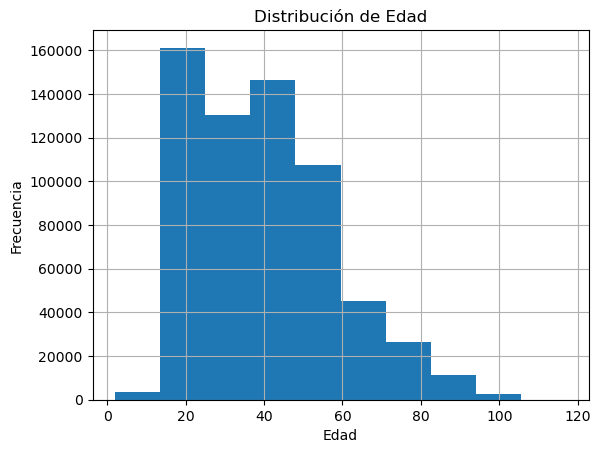

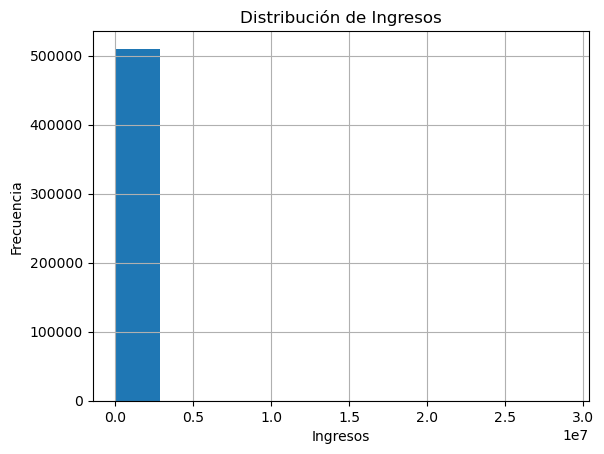

In [142]:

# Distribución de las características principales

dataset['edad'].hist()
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

dataset['imp_renta'].hist()
plt.title('Distribución de Ingresos')
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia')
plt.show()


In [143]:
# Limpiar datos
dataset['edad'].fillna(dataset['edad'].mean(), inplace=True)
dataset['imp_renta'].fillna(dataset['imp_renta'].mean(), inplace=True)

# Feature Engineering
dataset['nueva_caracteristica'] = dataset['edad'] * dataset['imp_renta']

# Verificar cambios
print(dataset.head())


   mes  pais  sexo  edad     fecha1 xti_empleado  xti_nuevo_cliente  \
0    1     1   0.0  35.0 2015-01-12            N                0.0   
1    1     1   1.0  27.0 2012-08-10            N                0.0   
2    1     1   1.0  37.0 2012-08-10            N                0.0   
3    1     1   0.0  23.0 2012-08-10            N                0.0   
4    1     1   0.0  44.0 2012-08-10            N                0.0   

  num_antiguedad  xti_rel fec_ult_cli_1t  ...  ind_prod17 ind_prod18  \
0              6      1.0            NaN  ...           0          0   
1             35      1.0            NaN  ...           0          0   
2             35      1.0            NaN  ...           0          0   
3             35      1.0            NaN  ...           0          0   
4             35      1.0            NaN  ...           0          0   

  ind_prod19 ind_prod20 ind_prod21 ind_prod22  ind_prod23  ind_prod24  \
0          0          0          0        0.0         0.0          

In [144]:


# Convertir columnas con valores mixtos a numéricos
dataset['num_antiguedad'] = pd.to_numeric(dataset['num_antiguedad'], errors='coerce')
dataset['num_antiguedad'].fillna(dataset['num_antiguedad'].mean(), inplace=True)
dataset['xti_rel_1mes'] = pd.to_numeric(dataset['xti_rel_1mes'], errors='coerce')
dataset['xti_rel_1mes'].fillna(dataset['xti_rel_1mes'].mean(), inplace=True)

# Convertir columnas categóricas en variables dummy
categorical_columns = ['pais', 'sexo', 'xti_empleado', 'xti_rel', 'indresi', 'indext', 'des_canal', 'xti_extra', 'tip_rel_1mes']
dataset = pd.get_dummies(dataset, columns=categorical_columns)



dataset.columns

Index(['mes', 'edad', 'fecha1', 'xti_nuevo_cliente', 'num_antiguedad',
       'fec_ult_cli_1t', 'xti_rel_1mes', 'tip_dom', 'cod_provincia',
       'xti_actividad_cliente',
       ...
       'des_canal_KHO', 'des_canal_KHP', 'des_canal_KHQ', 'des_canal_RED',
       'xti_extra_N', 'xti_extra_S', 'tip_rel_1mes_A', 'tip_rel_1mes_I',
       'tip_rel_1mes_P', 'tip_rel_1mes_R'],
      dtype='object', length=232)

In [145]:

# Verificar los cambios
print(dataset.info())
print(dataset.head())

# Separar características y targets
X = dataset.drop(columns=[f'ind_prod{i}' for i in range(1, 26)])
y = dataset[[f'ind_prod{i}' for i in range(1, 26)]]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634682 entries, 0 to 634681
Columns: 232 entries, mes to tip_rel_1mes_R
dtypes: bool(193), datetime64[ns](1), float64(12), int64(24), object(2)
memory usage: 305.7+ MB
None
   mes  edad     fecha1  xti_nuevo_cliente  num_antiguedad fec_ult_cli_1t  \
0    1  35.0 2015-01-12                0.0             6.0            NaN   
1    1  27.0 2012-08-10                0.0            35.0            NaN   
2    1  37.0 2012-08-10                0.0            35.0            NaN   
3    1  23.0 2012-08-10                0.0            35.0            NaN   
4    1  44.0 2012-08-10                0.0            35.0            NaN   

   xti_rel_1mes  tip_dom  cod_provincia  xti_actividad_cliente  ...  \
0           1.0      1.0           29.0                    1.0  ...   
1           1.0      1.0           40.0                    0.0  ...   
2           1.0      1.0            8.0                    0.0  ...   
3           1.0      1.0      

In [146]:

# Entrenar el modelo
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)

# Generar predicciones
predicciones = modelo.predict(X_test)

# Convertir predicciones y valores reales a listas de listas para MAP@7
y_test_list = [list(np.where(row == 1)[0] + 1) for row in y_test.values]
predicciones_list = [list(np.argsort(row)[-7:][::-1] + 1) for row in predicciones]

# Calcular MAP@7
score = mapk(y_test_list, predicciones_list, 7)
print(f'MAP@7 Score: {score}')

TypeError: Cannot cast DatetimeArray to dtype float32